In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import glob
import cmocean
from matplotlib.gridspec import GridSpec
from scipy.integrate import cumtrapz   # for time integration of CDR 

In [2]:
# --- FUNCTION to preprocess .txt files for consistent delimiters
def preprocess_txt(file_path):
    data = []  # Initialize a list to store the processed data

    # Initialize a flag to determine if we are reading the header
    is_header = True

    # Read the file line by line and process the data
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace
            if is_header:
                # Split the first line into column names
                column_names = re.split(r'\s+', line)
                is_header = False
            else:
                # Split the other lines into data values
                values = re.split(r'\s+', line)
                data.append(values)

    # Create a DataFrame with the processed data and set column names
    df = pd.DataFrame(data, columns=column_names)
    # return
    return df

In [3]:
# --- read in flux data from two runs
# flux data are colum integrated fluxes with all timesteps in a single file

# where results are stored 
results_path = "/home/tykukla/SCEPTER-1.0/scepter_output"
results_dir = {"spinup": "test_site_311_v2_field"}
# results_dir = {"basalt": "basApp_gbas_field_tpH6p8_tau1"}
# results_dir = {"seasonal": "bas_SEASON-30yr_gbas_field_tpH6p2_tau30"}
# results_dir = {"seasonal": "bas_shell_testrun_Sik01_gbas_field_tau45"}

# define file name pattern
# fn_pref = ["int_flx_co2sp", "flx_co2sp" "int_flx_gas", "flx_gas"]   # will read in all species unless fn_varInclude is defined
fn_pref = ["flx_gas-pco2"]   # will read in all species unless fn_varInclude is defined
fn_varInclude = []
varCheck = True if len(fn_varInclude) > 0 else False
fn_ext = ".txt"

# loop through runs
df = pd.DataFrame()  # initialize empty df to store dat
for key, run in results_dir.items():
    # get these paths
    flx_path, prof_path = os.path.join(results_path, run, "flx"), os.path.join(results_path, run, "prof")

    # loop through variables
    for fset in fn_pref:
        # set pattern
        fn_pattern = f"{fset}*{fn_ext}"
        # get list of filenames
        file_paths = glob.glob(f"{flx_path}/{fn_pattern}")

        # read in data and concatenate
        for file_path in file_paths:
            # get the variable 
            varpattern = re.escape(fset) + r'(.*?).txt'
            varmatch = re.search(varpattern, file_path)
            var = varmatch.group(1)
            # skip this step if it's not in the include arr
            if varCheck:
                if var not in fn_varInclude:
                    continue
            # read in
            dfi = preprocess_txt(file_path)
            # apply pd.to_numeric to all columns using the "map" method
            dfi = dfi.map(pd.to_numeric)
            # add set, var, and key
            dfi["set"] = fset
            dfi["var"] = var
            dfi["run_id"] = key
            # combine
            df = pd.concat([df, dfi], ignore_index=True)

# sort by time and depth
df = df.sort_values(by=["var", "time"])
df

,time,tflx,adv,dif,rain,inrt,g2,amnt,res,set,var,run_id
0,0.083334,7.177098e-02,0.011302,0.142415,0.0,0.0,-0.225488,0.0,-3.153179e-15,flx_gas-pco2,,spinup
1,0.250001,1.328366e-01,0.077947,0.463287,0.0,0.0,-0.674070,0.0,-6.963530e-15,flx_gas-pco2,,spinup
2,0.833334,1.311405e-01,0.400104,1.686305,0.0,0.0,-2.217550,0.0,-1.956077e-14,flx_gas-pco2,,spinup
3,2.500001,6.226957e-02,0.928601,5.427874,0.0,0.0,-6.418744,0.0,-5.951032e-15,flx_gas-pco2,,spinup
4,4.166668,3.898238e-02,1.136202,9.161869,0.0,0.0,-10.337053,0.0,7.390384e-15,flx_gas-pco2,,spinup
...,...,...,...,...,...,...,...,...,...,...,...,...
59,8333.333334,1.302240e-14,2.124058,61.841084,0.0,0.0,-63.965142,0.0,3.485375e-14,flx_gas-pco2,,spinup
60,8750.000001,3.537448e-13,2.124058,61.841084,0.0,0.0,-63.965142,0.0,-2.252894e-14,flx_gas-pco2,,spinup
61,9166.666668,-4.214848e-13,2.124058,61.841084,0.0,0.0,-63.965142,0.0,5.100050e-15,flx_gas-pco2,,spinup
62,9583.333334,1.007350e-13,2.124058,61.841084,0.0,0.0,-63.965142,0.0,3.419637e-14,flx_gas-pco2,,spinup


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


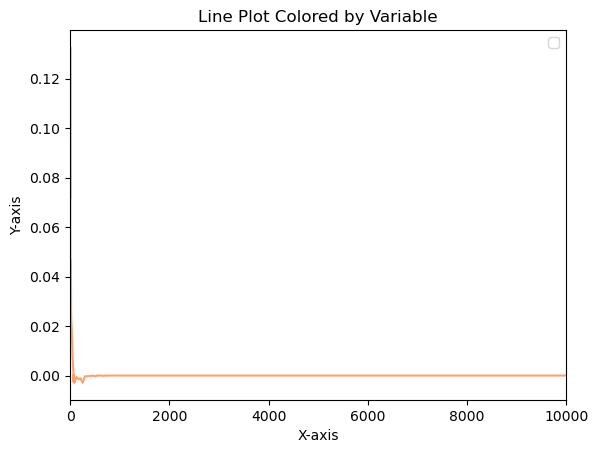

In [6]:
# --- plot CDR per year (lines colored by the set)
cdvar = "tflx"    # variable to plot

# aesthetics
logX = False
logY = False
mycmap = "magma"   # name of colormap
# cmap start and end percentages
start_percentage = 0.2
end_percentage = 0.8

# ax limits
xmin, xmax = 0,1e4

# colormap
cmap = plt.get_cmap(mycmap)  # Get the colormap
cmap = cmap.reversed()   # flip colormap
# -- no log normalization
norm = plt.Normalize(df['time'].min(), df['time'].max())  # Normalize time values for colormap


# --- PLOT
# Create a plot for each time step
# split by set
plt.plot(df['time'], df[cdvar], color=cmap(0.2), linestyle="-")

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
if logX:
    plt.xscale('log')
    plt.xlim([0.1, 100])
if logY:
    plt.yscale('log')
    plt.ylim([0.0001, 15])
plt.title('Line Plot Colored by Variable')
plt.xlim([xmin, xmax])
# Add legend
plt.legend()
plt.show();